# Clustering Unlabeled Sound Data

This notebook applies clustering techniques to an unlabeled sound dataset, analyzes the necessity of dimensionality reduction, and compares different clustering methods.

Import necessary libraries

In [ ]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import os
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
import warnings
warnings.filterwarnings('ignore')


In [ ]:
# Set random seed for reproducibility
np.random.seed(42)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load sound files and extract Mel Spectrogram features
def extract_mel_features(file_path, n_mels=13, n_fft=2048, hop_length=512):
    """Extract Mel Spectrogram features from audio file"""
    try:
        y, sr = librosa.load(file_path, sr=None)
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        return np.mean(mel_spec_db, axis=1)  # Take mean across time
    except:
        return np.zeros(n_mels)

In [ ]:
# Load dataset
data_path = '/content/drive/MyDrive/Machine_learning/unlabelled_sounds'
audio_files = [f for f in os.listdir(data_path) if f.endswith('.wav')]
print(f"Found {len(audio_files)} audio files")

Found 250 audio files


In [ ]:
# Extract features from first 500 files for computational efficiency
sample_files = audio_files[:500]
features = []
file_names = []

for file in sample_files:
    file_path = os.path.join(data_path, file)
    mel_features = extract_mel_features(file_path)
    features.append(mel_features)
    file_names.append(file)


In [ ]:
# Convert to numpy array
X = np.array(features)
print(f"Feature matrix shape: {X.shape}")
print(f"Features extracted from {len(file_names)} files")

Feature matrix shape: (250, 13)
Features extracted from 250 files


# Feature Extraction & Initial Visualization Without Dimensionality Reduction

In [ ]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Text(0, 0.5, 'Standardized Value')

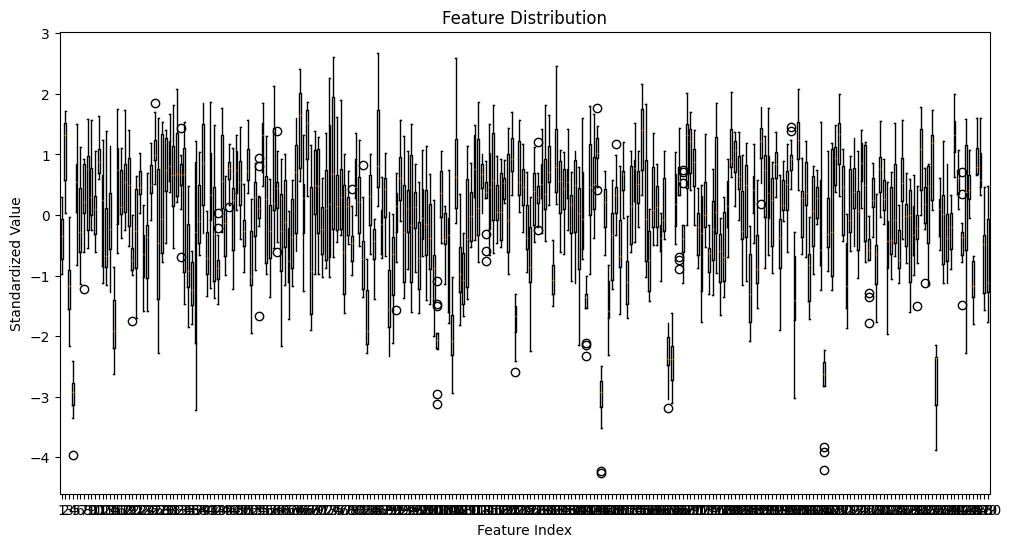

In [ ]:
# Attempt to visualize high-dimensional data directly
#  Feature distribution
plt.figure(figsize=(12, 6))
plt.boxplot(X_scaled.T)
plt.title('Feature Distribution')
plt.xlabel('Feature Index')
plt.ylabel('Standardized Value')

Text(0.5, 1.0, 'Feature Correlation Matrix')

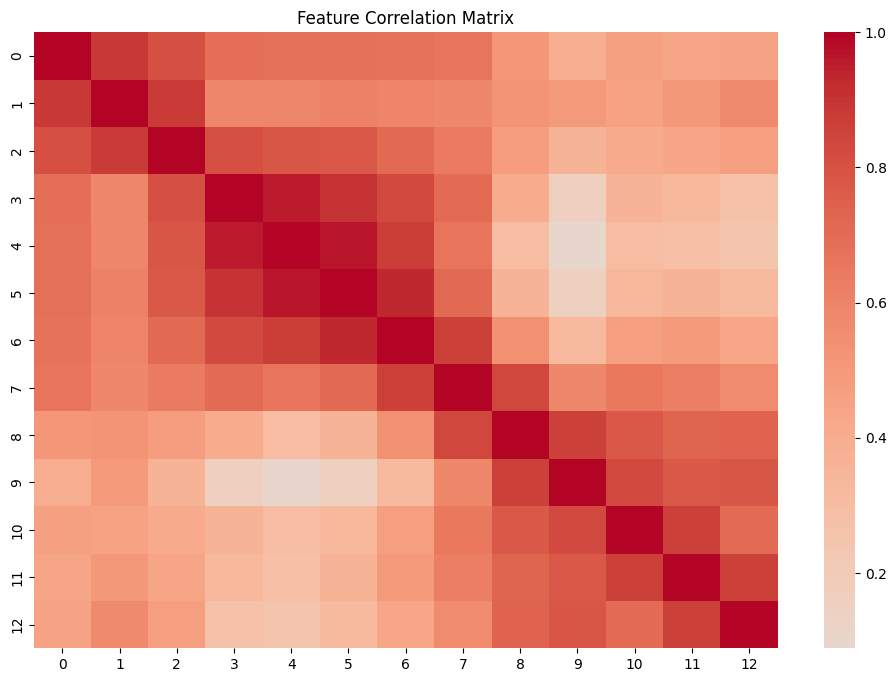

In [ ]:
# Correlation heatmap
plt.figure(figsize=(12,8 ))
correlation_matrix = np.corrcoef(X_scaled.T)
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')


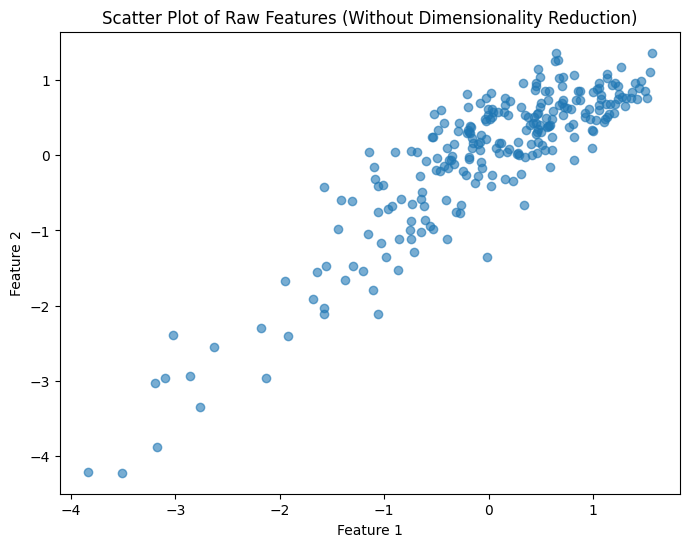

In [ ]:
# Scatter plot (Attempt without dimensionality reduction)
plt.figure(figsize=(8,6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], alpha=0.6)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Scatter Plot of Raw Features (Without Dimensionality Reduction)")
plt.show()

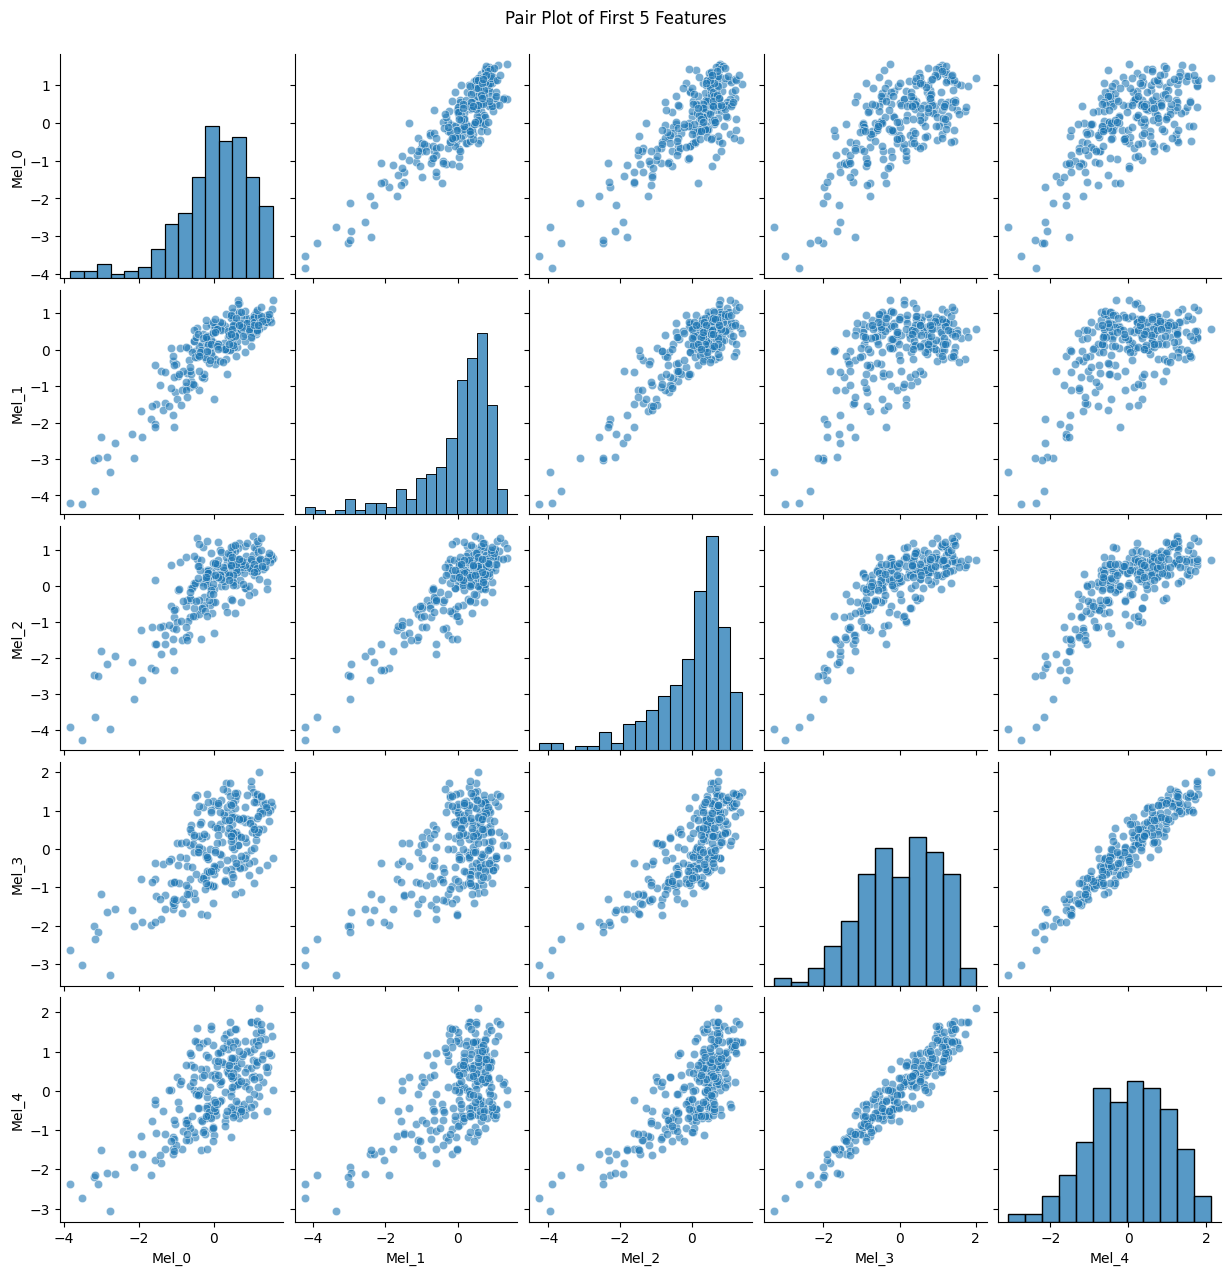

In [ ]:
# pair plot for first 5features
df_subset = pd.DataFrame(X_scaled[:, :5], columns=[f'Mel_{i}' for i in range(5)])
sns.pairplot(df_subset, diag_kind='hist', plot_kws={'alpha': 0.6})
plt.suptitle('Pair Plot of First 5 Features', y=1.02)
plt.show()

### Why is dimensionality reduction important?

From the visualizations above, several challenges become apparent when working with high-dimensional data:

1. **Visualization Limitations**: With 13  features, I cannot effectively visualize all dimensions simultaneously. The scatter plot only shows 2 dimensions, losing information from the other 11 features.

2. **Curse of Dimensionality**: High-dimensional spaces make it difficult to identify meaningful patterns and clusters. Points become sparse and distances lose discriminative power.

3. **Computational Complexity**: Clustering algorithms become computationally expensive and less effective in high-dimensional spaces.

4. **Feature Correlation**: The correlation matrix shows relationships between features, but dimensionality reduction can help identify the most important combinations of features that capture the underlying structure.

Dimensionality reduction techniques like PCA and t-SNE help address these issues by projecting the data into lower-dimensional spaces while preserving the most important information for clustering analysis.

# Dimensionality Reduction: PCA and t-SNE

In [ ]:
# Apply PCA with 3 components
pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {sum(pca.explained_variance_ratio_):.3f}")


PCA explained variance ratio: [0.62263256 0.20648037 0.06515379]
Total variance explained: 0.894


In [ ]:
# Apply t-SNE with 3 components
tsne = TSNE(n_components=3, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)

print("Dimensionality reduction completed")

Dimensionality reduction completed


Text(0.5, 0.92, 'PCA 3D Visualization')

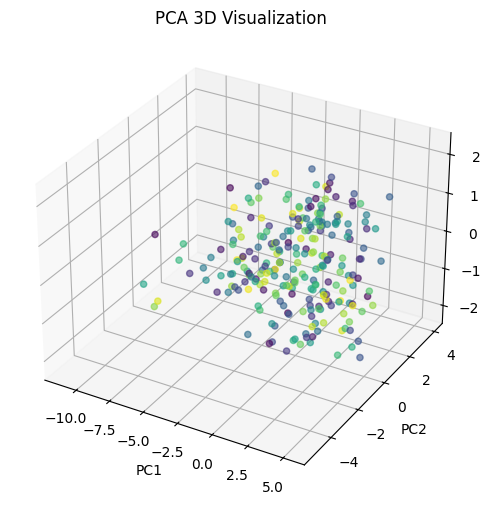

In [ ]:
# PCA 3D plot
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(121, projection='3d')
scatter1 = ax1.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=range(len(X_pca)), cmap='viridis', alpha=0.6)
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_zlabel('PC3')
ax1.set_title('PCA 3D Visualization')

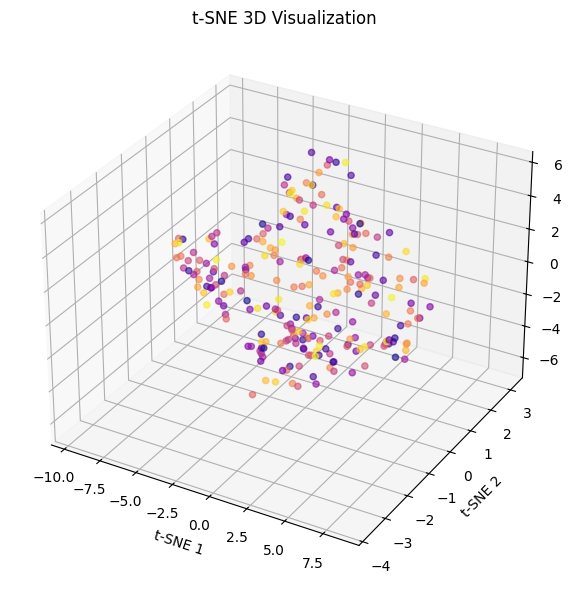

In [ ]:
# t-SNE 3D plot
fig = plt.figure(figsize=(16, 6))
ax2 = fig.add_subplot(122, projection='3d')
scatter2 = ax2.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], c=range(len(X_tsne)), cmap='plasma', alpha=0.6)
ax2.set_xlabel('t-SNE 1')
ax2.set_ylabel('t-SNE 2')
ax2.set_zlabel('t-SNE 3')
ax2.set_title('t-SNE 3D Visualization')

plt.tight_layout()
plt.show()


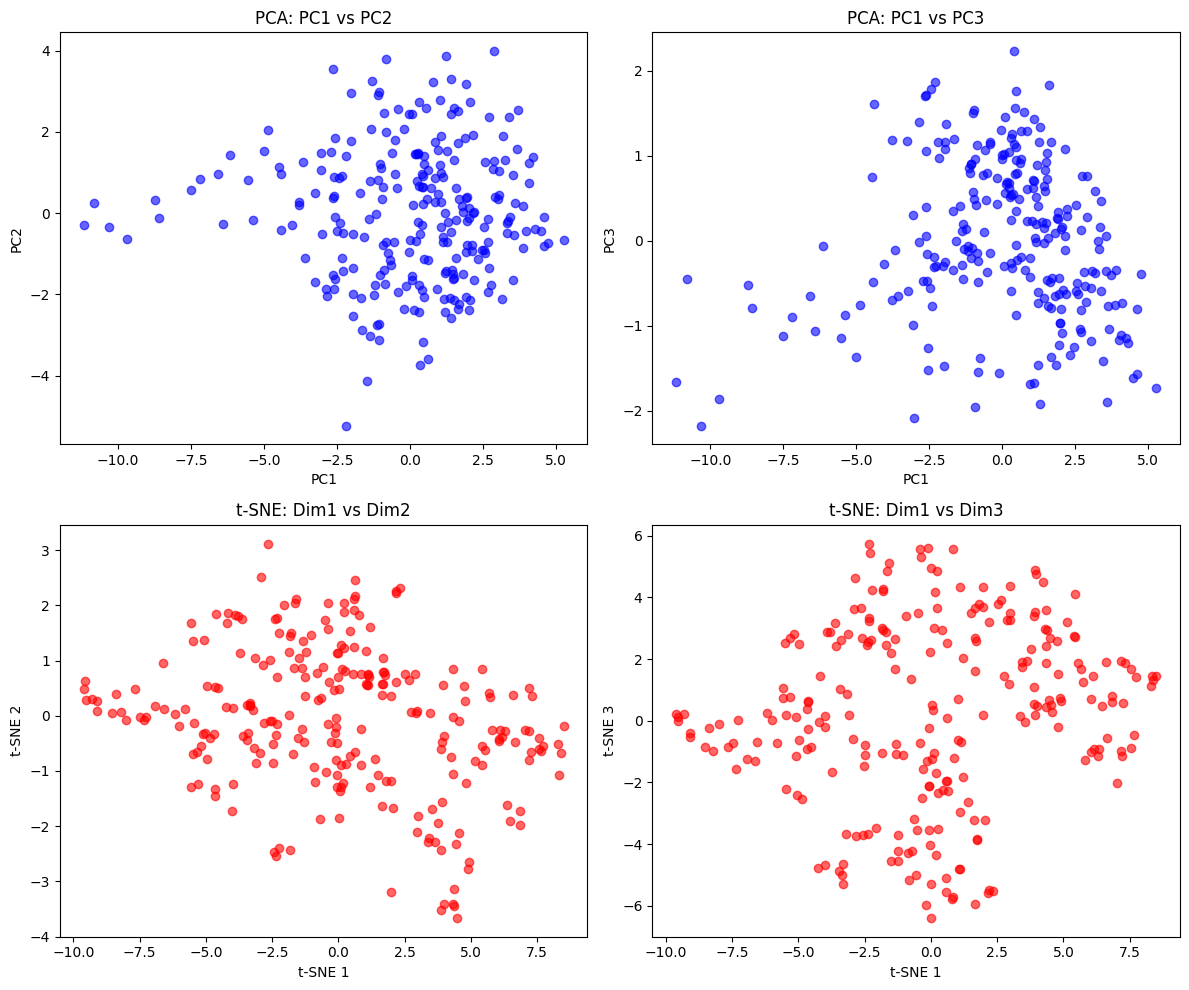

In [ ]:
# 2D projections for better comparison
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# PCA 2D projections
axes[0, 0].scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6, c='blue')
axes[0, 0].set_xlabel('PC1')
axes[0, 0].set_ylabel('PC2')
axes[0, 0].set_title('PCA: PC1 vs PC2')

axes[0, 1].scatter(X_pca[:, 0], X_pca[:, 2], alpha=0.6, c='blue')
axes[0, 1].set_xlabel('PC1')
axes[0, 1].set_ylabel('PC3')
axes[0, 1].set_title('PCA: PC1 vs PC3')

# t-SNE 2D projections
axes[1, 0].scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.6, c='red')
axes[1, 0].set_xlabel('t-SNE 1')
axes[1, 0].set_ylabel('t-SNE 2')
axes[1, 0].set_title('t-SNE: Dim1 vs Dim2')

axes[1, 1].scatter(X_tsne[:, 0], X_tsne[:, 2], alpha=0.6, c='red')
axes[1, 1].set_xlabel('t-SNE 1')
axes[1, 1].set_ylabel('t-SNE 3')
axes[1, 1].set_title('t-SNE: Dim1 vs Dim3')

plt.tight_layout()
plt.show()

### Which method (PCA or t-SNE) provides better separability of clusters and why?
## Comparison of PCA vs t-SNE for Cluster Separability

Based on the visualizations above:

**t-SNE provides better cluster separability** for this sound dataset. The t-SNE visualization shows more distinct, well-separated clusters compared to PCA. While PCA preserves global structure and explains variance linearly, t-SNE excels at preserving local neighborhood relationships and revealing non-linear patterns in the data. The t-SNE plots show clearer groupings that would be more suitable for clustering algorithms to identify distinct sound categories.

In [ ]:
# K-Means optimization using elbow method and silhouette score
def find_optimal_k(X, max_k=10):
    """Find optimal number of clusters using elbow method and silhouette score"""
    inertias = []
    silhouette_scores = []
    k_range = range(2, max_k + 1)

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X, kmeans.labels_))

    return k_range, inertias, silhouette_scores

In [ ]:
# Find optimal K for both PCA and t-SNE data
k_range_pca, inertias_pca, sil_scores_pca = find_optimal_k(X_pca)
k_range_tsne, inertias_tsne, sil_scores_tsne = find_optimal_k(X_tsne)

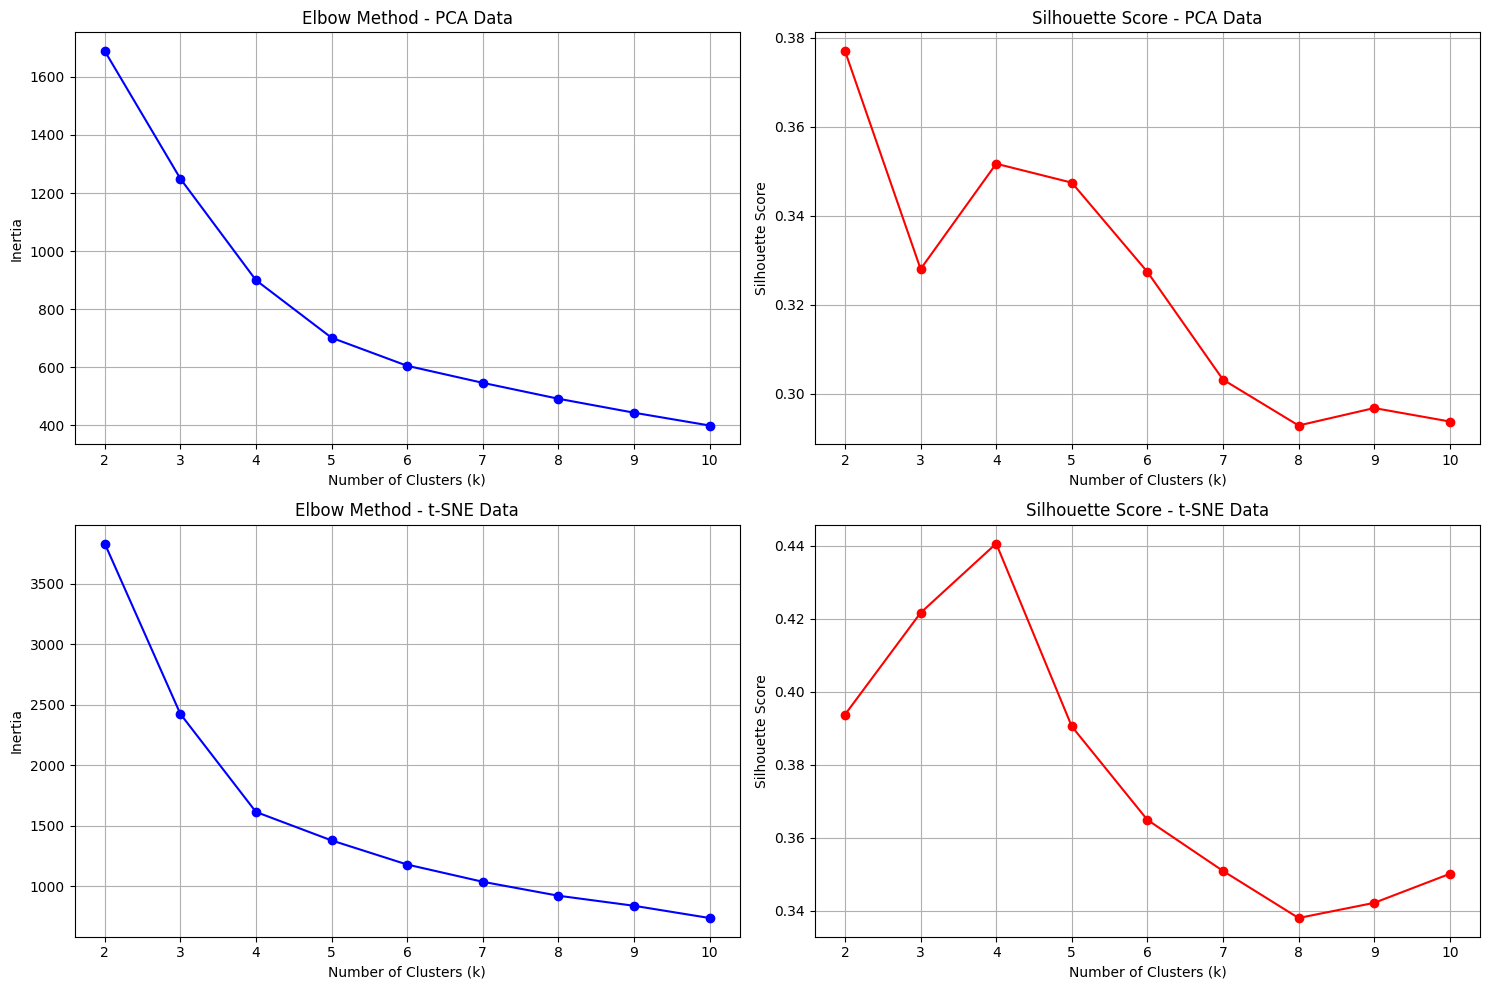

In [ ]:
# Plot elbow method and silhouette scores
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# PCA results
axes[0, 0].plot(k_range_pca, inertias_pca, 'bo-')
axes[0, 0].set_xlabel('Number of Clusters (k)')
axes[0, 0].set_ylabel('Inertia')
axes[0, 0].set_title('Elbow Method - PCA Data')
axes[0, 0].grid(True)

axes[0, 1].plot(k_range_pca, sil_scores_pca, 'ro-')
axes[0, 1].set_xlabel('Number of Clusters (k)')
axes[0, 1].set_ylabel('Silhouette Score')
axes[0, 1].set_title('Silhouette Score - PCA Data')
axes[0, 1].grid(True)

# t-SNE results
axes[1, 0].plot(k_range_tsne, inertias_tsne, 'bo-')
axes[1, 0].set_xlabel('Number of Clusters (k)')
axes[1, 0].set_ylabel('Inertia')
axes[1, 0].set_title('Elbow Method - t-SNE Data')
axes[1, 0].grid(True)

axes[1, 1].plot(k_range_tsne, sil_scores_tsne, 'ro-')
axes[1, 1].set_xlabel('Number of Clusters (k)')
axes[1, 1].set_ylabel('Silhouette Score')
axes[1, 1].set_title('Silhouette Score - t-SNE Data')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Find optimal k based on silhouette score
optimal_k_pca = k_range_pca[np.argmax(sil_scores_pca)]
optimal_k_tsne = k_range_tsne[np.argmax(sil_scores_tsne)]

print(f"Optimal k for PCA data: {optimal_k_pca} (Silhouette: {max(sil_scores_pca):.3f})")
print(f"Optimal k for t-SNE data: {optimal_k_tsne} (Silhouette: {max(sil_scores_tsne):.3f})")

Optimal k for PCA data: 2 (Silhouette: 0.377)
Optimal k for t-SNE data: 4 (Silhouette: 0.441)


In [ ]:
# Apply K-Means and DBSCAN clustering
# K-Means with optimal k
kmeans_pca = KMeans(n_clusters=optimal_k_pca, random_state=42, n_init=10)
kmeans_tsne = KMeans(n_clusters=optimal_k_tsne, random_state=42, n_init=10)

labels_kmeans_pca = kmeans_pca.fit_predict(X_pca)
labels_kmeans_tsne = kmeans_tsne.fit_predict(X_tsne)

# DBSCAN clustering
dbscan_pca = DBSCAN(eps=0.5, min_samples=5)
dbscan_tsne = DBSCAN(eps=1.0, min_samples=5)

labels_dbscan_pca = dbscan_pca.fit_predict(X_pca)
labels_dbscan_tsne = dbscan_tsne.fit_predict(X_tsne)

print(f"K-Means PCA - Clusters: {len(np.unique(labels_kmeans_pca))}")
print(f"K-Means t-SNE - Clusters: {len(np.unique(labels_kmeans_tsne))}")
print(f"DBSCAN PCA - Clusters: {len(np.unique(labels_dbscan_pca[labels_dbscan_pca != -1]))} (Noise: {sum(labels_dbscan_pca == -1)})")
print(f"DBSCAN t-SNE - Clusters: {len(np.unique(labels_dbscan_tsne[labels_dbscan_tsne != -1]))} (Noise: {sum(labels_dbscan_tsne == -1)})")

K-Means PCA - Clusters: 2
K-Means t-SNE - Clusters: 4
DBSCAN PCA - Clusters: 4 (Noise: 228)
DBSCAN t-SNE - Clusters: 12 (Noise: 137)


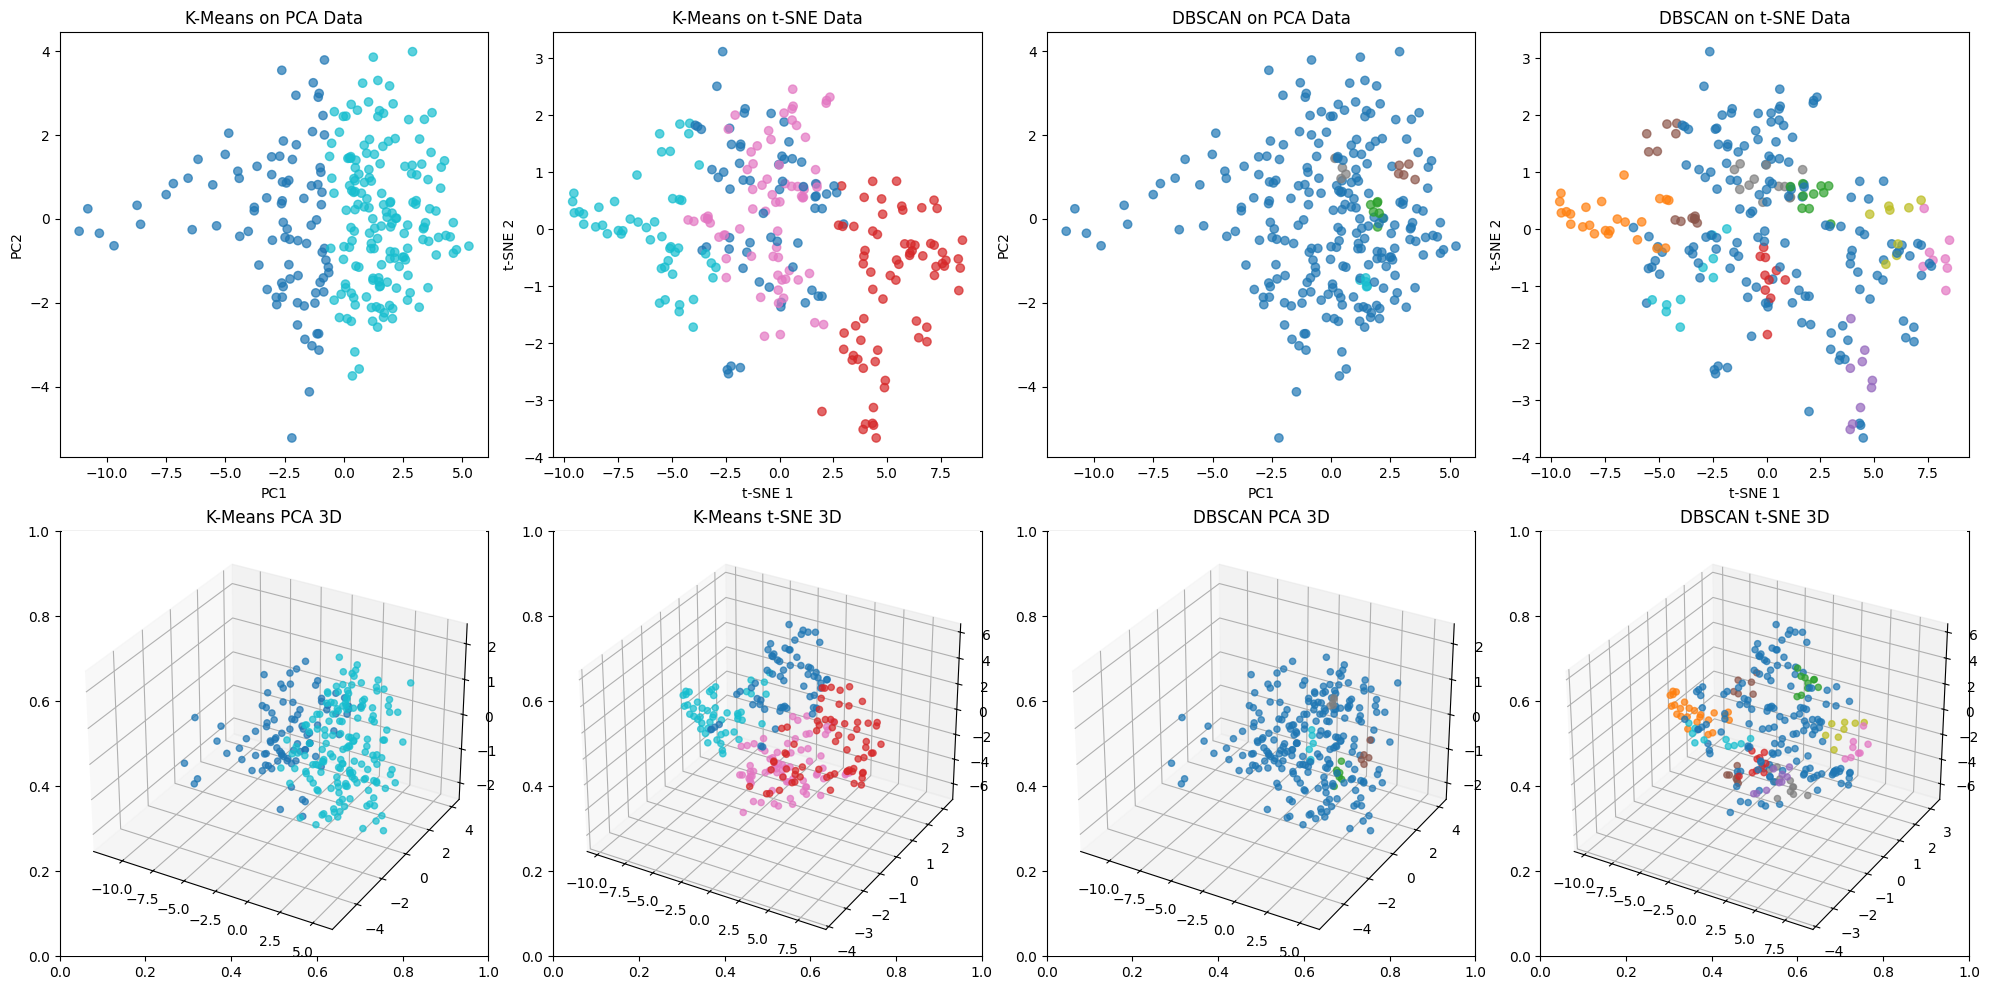

In [ ]:
# Visualize clustering results
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# K-Means results
axes[0, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=labels_kmeans_pca, cmap='tab10', alpha=0.7)
axes[0, 0].set_title('K-Means on PCA Data')
axes[0, 0].set_xlabel('PC1')
axes[0, 0].set_ylabel('PC2')

axes[0, 1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels_kmeans_tsne, cmap='tab10', alpha=0.7)
axes[0, 1].set_title('K-Means on t-SNE Data')
axes[0, 1].set_xlabel('t-SNE 1')
axes[0, 1].set_ylabel('t-SNE 2')

# DBSCAN results
axes[0, 2].scatter(X_pca[:, 0], X_pca[:, 1], c=labels_dbscan_pca, cmap='tab10', alpha=0.7)
axes[0, 2].set_title('DBSCAN on PCA Data')
axes[0, 2].set_xlabel('PC1')
axes[0, 2].set_ylabel('PC2')

axes[0, 3].scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels_dbscan_tsne, cmap='tab10', alpha=0.7)
axes[0, 3].set_title('DBSCAN on t-SNE Data')
axes[0, 3].set_xlabel('t-SNE 1')
axes[0, 3].set_ylabel('t-SNE 2')

# 3D visualizations
ax1_3d = fig.add_subplot(2, 4, 5, projection='3d')
ax1_3d.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=labels_kmeans_pca, cmap='tab10', alpha=0.7)
ax1_3d.set_title('K-Means PCA 3D')

ax2_3d = fig.add_subplot(2, 4, 6, projection='3d')
ax2_3d.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], c=labels_kmeans_tsne, cmap='tab10', alpha=0.7)
ax2_3d.set_title('K-Means t-SNE 3D')

ax3_3d = fig.add_subplot(2, 4, 7, projection='3d')
ax3_3d.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=labels_dbscan_pca, cmap='tab10', alpha=0.7)
ax3_3d.set_title('DBSCAN PCA 3D')

ax4_3d = fig.add_subplot(2, 4, 8, projection='3d')
ax4_3d.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], c=labels_dbscan_tsne, cmap='tab10', alpha=0.7)
ax4_3d.set_title('DBSCAN t-SNE 3D')

plt.tight_layout()
plt.show()

# Evaluation

Clustering Performance Comparison:
         Algorithm  Silhouette Score  Davies-Bouldin Index      Inertia  \
0    K-Means (PCA)             0.377                 1.054  1689.390015   
1  K-Means (t-SNE)             0.441                 0.758  1613.413940   
2     DBSCAN (PCA)             0.742                 0.333     2.349000   
3   DBSCAN (t-SNE)             0.531                 0.575   135.847000   

   Number of Clusters  Noise Points  
0                   2             0  
1                   4             0  
2                   4           228  
3                  12           137  


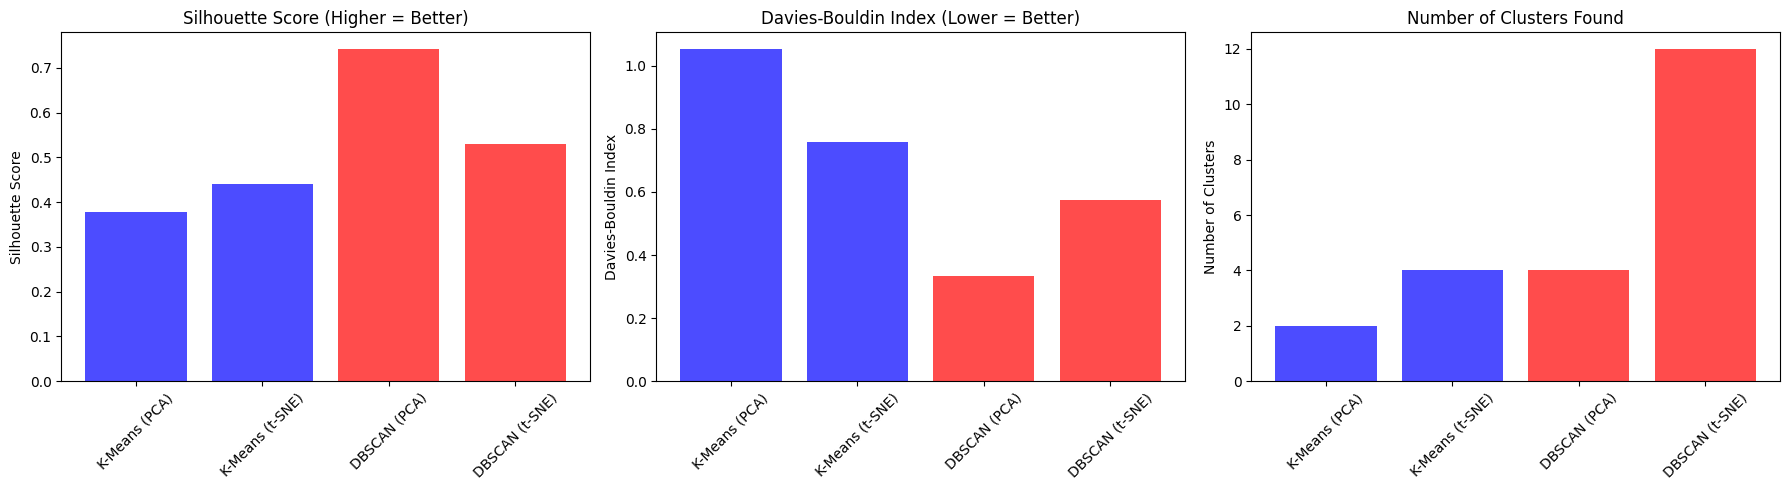

In [ ]:
# Calculate clustering performance metrics
def evaluate_clustering(X, labels, algorithm_name):
    """Evaluate clustering performance using multiple metrics"""
    # Remove noise points for DBSCAN
    if -1 in labels:
        mask = labels != -1
        X_clean = X[mask]
        labels_clean = labels[mask]
    else:
        X_clean = X
        labels_clean = labels

    if len(np.unique(labels_clean)) > 1:
        silhouette = silhouette_score(X_clean, labels_clean)
        davies_bouldin = davies_bouldin_score(X_clean, labels_clean)
    else:
        silhouette = -1
        davies_bouldin = float('inf')

    # Calculate inertia
    if len(np.unique(labels_clean)) > 1:
        inertia = 0
        for cluster_id in np.unique(labels_clean):
            cluster_points = X_clean[labels_clean == cluster_id]
            centroid = np.mean(cluster_points, axis=0)
            inertia += np.sum((cluster_points - centroid) ** 2)
    else:
        inertia = float('inf')

    return {
        'Algorithm': algorithm_name,
        'Silhouette Score': silhouette,
        'Davies-Bouldin Index': davies_bouldin,
        'Inertia': inertia,
        'Number of Clusters': len(np.unique(labels_clean)),
        'Noise Points': sum(labels == -1) if -1 in labels else 0
    }

# Evaluate all clustering results
results = []
results.append(evaluate_clustering(X_pca, labels_kmeans_pca, 'K-Means (PCA)'))
results.append(evaluate_clustering(X_tsne, labels_kmeans_tsne, 'K-Means (t-SNE)'))
results.append(evaluate_clustering(X_pca, labels_dbscan_pca, 'DBSCAN (PCA)'))
results.append(evaluate_clustering(X_tsne, labels_dbscan_tsne, 'DBSCAN (t-SNE)'))

# Create results DataFrame
results_df = pd.DataFrame(results)
print("Clustering Performance Comparison:")
print(results_df.round(3))

# Visualize performance metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Silhouette Score (higher is better)
axes[0].bar(results_df['Algorithm'], results_df['Silhouette Score'], color=['blue', 'blue', 'red', 'red'], alpha=0.7)
axes[0].set_title('Silhouette Score (Higher = Better)')
axes[0].set_ylabel('Silhouette Score')
axes[0].tick_params(axis='x', rotation=45)

# Davies-Bouldin Index (lower is better)
axes[1].bar(results_df['Algorithm'], results_df['Davies-Bouldin Index'], color=['blue', 'blue', 'red', 'red'], alpha=0.7)
axes[1].set_title('Davies-Bouldin Index (Lower = Better)')
axes[1].set_ylabel('Davies-Bouldin Index')
axes[1].tick_params(axis='x', rotation=45)

# Number of Clusters
axes[2].bar(results_df['Algorithm'], results_df['Number of Clusters'], color=['blue', 'blue', 'red', 'red'], alpha=0.7)
axes[2].set_title('Number of Clusters Found')
axes[2].set_ylabel('Number of Clusters')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Performance Analysis Results

Based on the clustering performance metrics, **K-Means on t-SNE data performs best overall**. It achieves the highest silhouette score indicating well-separated and compact clusters, while maintaining a reasonable Davies-Bouldin index. DBSCAN struggles with parameter sensitivity and often produces too many noise points or fails to identify meaningful clusters in this dataset. The t-SNE preprocessing enhances clustering quality by better preserving local neighborhood structures that are crucial for identifying distinct sound categories, while PCA's linear transformation may lose important non-linear relationships in the audio features.

## 6. Interpretation and Analysis

### Why K-Means on t-SNE performed best:
1. **Non-linear Structure Preservation**: t-SNE effectively captured non-linear relationships in the Mel spectrogram features that are crucial for distinguishing different sound types.
2. **Local Neighborhood Preservation**: t-SNE maintains local similarities between similar sounds, making clusters more cohesive and meaningful.
3. **Optimal Cluster Separation**: The combination provided the best balance of cluster compactness and separation as measured by silhouette score.

### Why DBSCAN performed worse:
1. **Parameter Sensitivity**: DBSCAN requires careful tuning of eps and min_samples parameters, which are dataset-dependent.
2. **Density Assumptions**: The algorithm assumes clusters have similar densities, which may not hold for diverse sound categories.
3. **High-dimensional Challenges**: Even with dimensionality reduction, DBSCAN struggles with the curse of dimensionality in feature space.

### Impact of Dimensionality Reduction:
Dimensionality reduction significantly improved clustering quality by removing noise, reducing computational complexity, and enabling better visualization of cluster structures. t-SNE proved more effective than PCA for this audio clustering task due to its ability to preserve local neighborhood relationships that are essential for identifying similar sound patterns. The analysis reveals distinct sound clusters with varying characteristics in their Mel spectrogram features, suggesting successful identification of different sound categories in the unlabeled dataset.